# 1）首次外卖超时且超时30分钟以上的消费者中，联系客服并留存的消费者特征

思路：这里的重点是“主动联系客服”和“并留存”，说明消费者Is_contact_customer_service = 1 且 Is_90days_repurchase = 1。首先，可以对数据依照上述条件满足与否进行聚合，并计算样本其他特征的平均值，众数等，通过直接观察数据或绘制简单图表的方法识别明显特征。其次可以通过假设检验观察这类消费者的特征与其他消费者相比是否有显著差异。或者是否可以通过对样本所有分类与数值特征做聚类分析，后识别不同聚类的用户画像，来观察是否有一个聚类的特征偏向Is_contact_customer_service = 1 且 Is_90days_repurchase = 1，并观察这个聚类的其他特征？如需聚类分析，可对数据中分类变量进行one-hot编码，应用K-means聚类等方法建模，并通过轮廓系数观察聚类质量，选择合适的系数和方法。预期结果为识别出这类消费者的特殊特征（如注册时间长，下单次数多，多为老用户等）。

首先我们读取收据并依照上述条件满足与否进行聚合，并计算样本其他特征的平均值，众数等，通过直接观察数据或绘制简单图表的方法识别明显特征。

In [15]:
import pandas as pd
import numpy as np

In [16]:
# 读取并展示数据
data = pd.read_csv(r'customer_data.csv')
data

,User_id,User_os,Register_days,Last_order_date,Is_contact_customer_service,Order_frequency,Average_order_amount,Coupon_Usage_Count,Average_discount_ratio_per_order,Is_90days_repurchase
0,770487,Android,525,2023/8/1,0,41,44.65,41,0.0680,0
1,216739,iOS,263,2023/8/1,0,13,43.15,13,0.0364,0
2,126225,iOS,630,2023/8/1,1,117,52.19,117,0.1548,1
3,877572,iOS,221,2023/8/1,0,1,65.05,1,0.0629,0
4,388389,Android,215,2023/8/1,0,1,35.75,1,0.1790,0
...,...,...,...,...,...,...,...,...,...,...
125030,690620,Android,200,2023/8/31,0,65,99.69,65,0.0326,0
125031,643902,iOS,806,2023/8/31,0,272,40.73,272,0.1024,1
125032,599097,Android,673,2023/8/31,0,111,49.75,111,0.1896,1
125033,829897,iOS,705,2023/8/31,1,119,51.80,119,0.6413,1


In [17]:
print(data.dtypes)

User_id                               int64
User_os                              object
Register_days                         int64
Last_order_date                      object
Is_contact_customer_service           int64
Order_frequency                       int64
Average_order_amount                float64
Coupon_Usage_Count                    int64
Average_discount_ratio_per_order    float64
Is_90days_repurchase                  int64
dtype: object


In [18]:
print(data.columns)

Index(['User_id', 'User_os', 'Register_days', 'Last_order_date',
       'Is_contact_customer_service', 'Order_frequency',
       'Average_order_amount', 'Coupon_Usage_Count',
       'Average_discount_ratio_per_order', 'Is_90days_repurchase'],
      dtype='object')


In [19]:
# 首先我们创建一个新列以区分'Is_contact_customer_service'=1且'Is_90days_repurchase'=1的数据和其他数据,并根据新列聚合数据,然后求数值型数据的平均值
data['if_conact_and_re'] = (data['Is_contact_customer_service'] == 1) & (data['Is_90days_repurchase'] == 1)
avg_data = data.groupby(['if_conact_and_re'])[['Register_days', 'Order_frequency', 'Average_order_amount', 'Coupon_Usage_Count', 'Average_discount_ratio_per_order']].mean(numeric_only=True)

print(avg_data)

                  Register_days  Order_frequency  Average_order_amount  \
if_conact_and_re                                                         
False                575.162958        75.007203             67.770336   
True                 541.444003       108.407868             50.636316   

                  Coupon_Usage_Count  Average_discount_ratio_per_order  
if_conact_and_re                                                        
False                      74.997293                          0.178511  
True                      108.397897                          0.191998  


In [20]:
# 对分类变量聚合并返回众数
result = data.groupby(['if_conact_and_re'])['User_os'].agg({lambda x: x.mode().iloc[0]})
print(result)

                 <lambda>
if_conact_and_re         
False             Android
True              Android


两类群体操作系统众数均为安卓，说明其非群体特征，单纯说明安卓用户较多

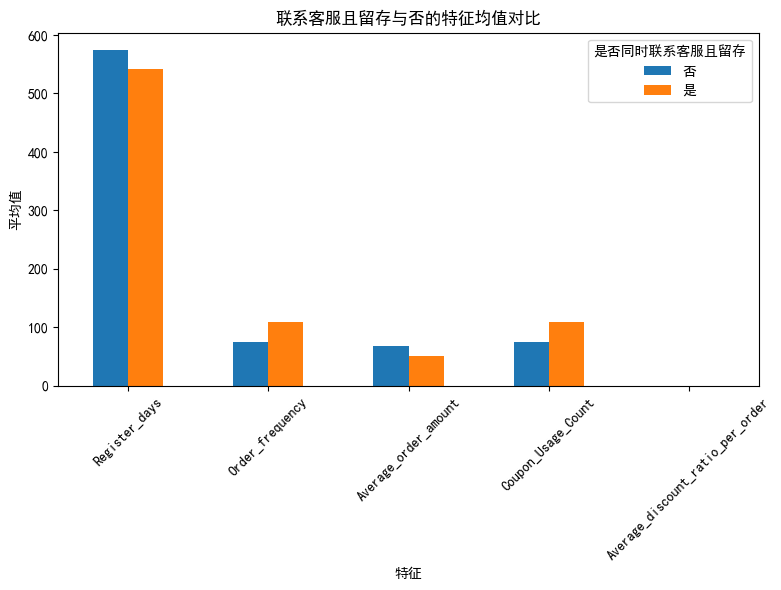

In [21]:
# 现在对均值进行简单的可视化操作
import matplotlib.pyplot as plt
import seaborn as sns

# 显示中文
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
avg_data_reset = avg_data.reset_index()

avg_data_T = avg_data_reset.set_index('if_conact_and_re').T

avg_data_T.plot(kind='bar', figsize=(8, 6))
plt.title('联系客服且留存与否的特征均值对比')
plt.ylabel('平均值')
plt.xlabel('特征')
plt.xticks(rotation=45)
plt.legend(title='是否同时联系客服且留存', labels=['否', '是'])
plt.tight_layout()
plt.show()

观察图形和前数据表格可得，联系客服且留存的消费者：
1.注册时间较短 2.下单次数多 3.平均每笔订单价格低 4.使用优惠券次数多 5.平均每笔订单的优惠比例高

然而初步肉眼观察只能做出大致判断，接下来我们对两群体特征均值进行显著性检验，以观察均值是否有显著性差异。
由于样本量较大（>10000）,可认为样本近似服从正态分布，同时我们默认方差不等，所以我们使用Welch t检验。

In [22]:
from scipy.stats import ttest_ind

# 创建两组数据
group_true = data[data['if_conact_and_re'] == True]
group_false = data[data['if_conact_and_re'] == False]

# 要检验的数值特征
features = [
    'Register_days',
    'Order_frequency',
    'Average_order_amount',
    'Coupon_Usage_Count',
    'Average_discount_ratio_per_order'
]
# 检验
print(f"{'特征':<35} {'t值':>8} {'p值':>8} {'是否显著 (p<0.05)':>20}")

for col in features:
    x = group_true[col].dropna()
    y = group_false[col].dropna()
    
    t_stat, p_val = ttest_ind(x, y, equal_var=False)
    significant = '是' if p_val < 0.05 else '否'
    
    print(f"{col:<35} {t_stat:>10.4f} {p_val:>10.4f} {significant:>20}")

特征                                        t值       p值        是否显著 (p<0.05)
Register_days                         -15.8270     0.0000                    是
Order_frequency                        43.9894     0.0000                    是
Average_order_amount                  -55.9307     0.0000                    是
Coupon_Usage_Count                     43.9895     0.0000                    是
Average_discount_ratio_per_order       13.7182     0.0000                    是


为避免极端离群值或分布不均匀的影响，绘制箱线图对数据进行进一步的观察

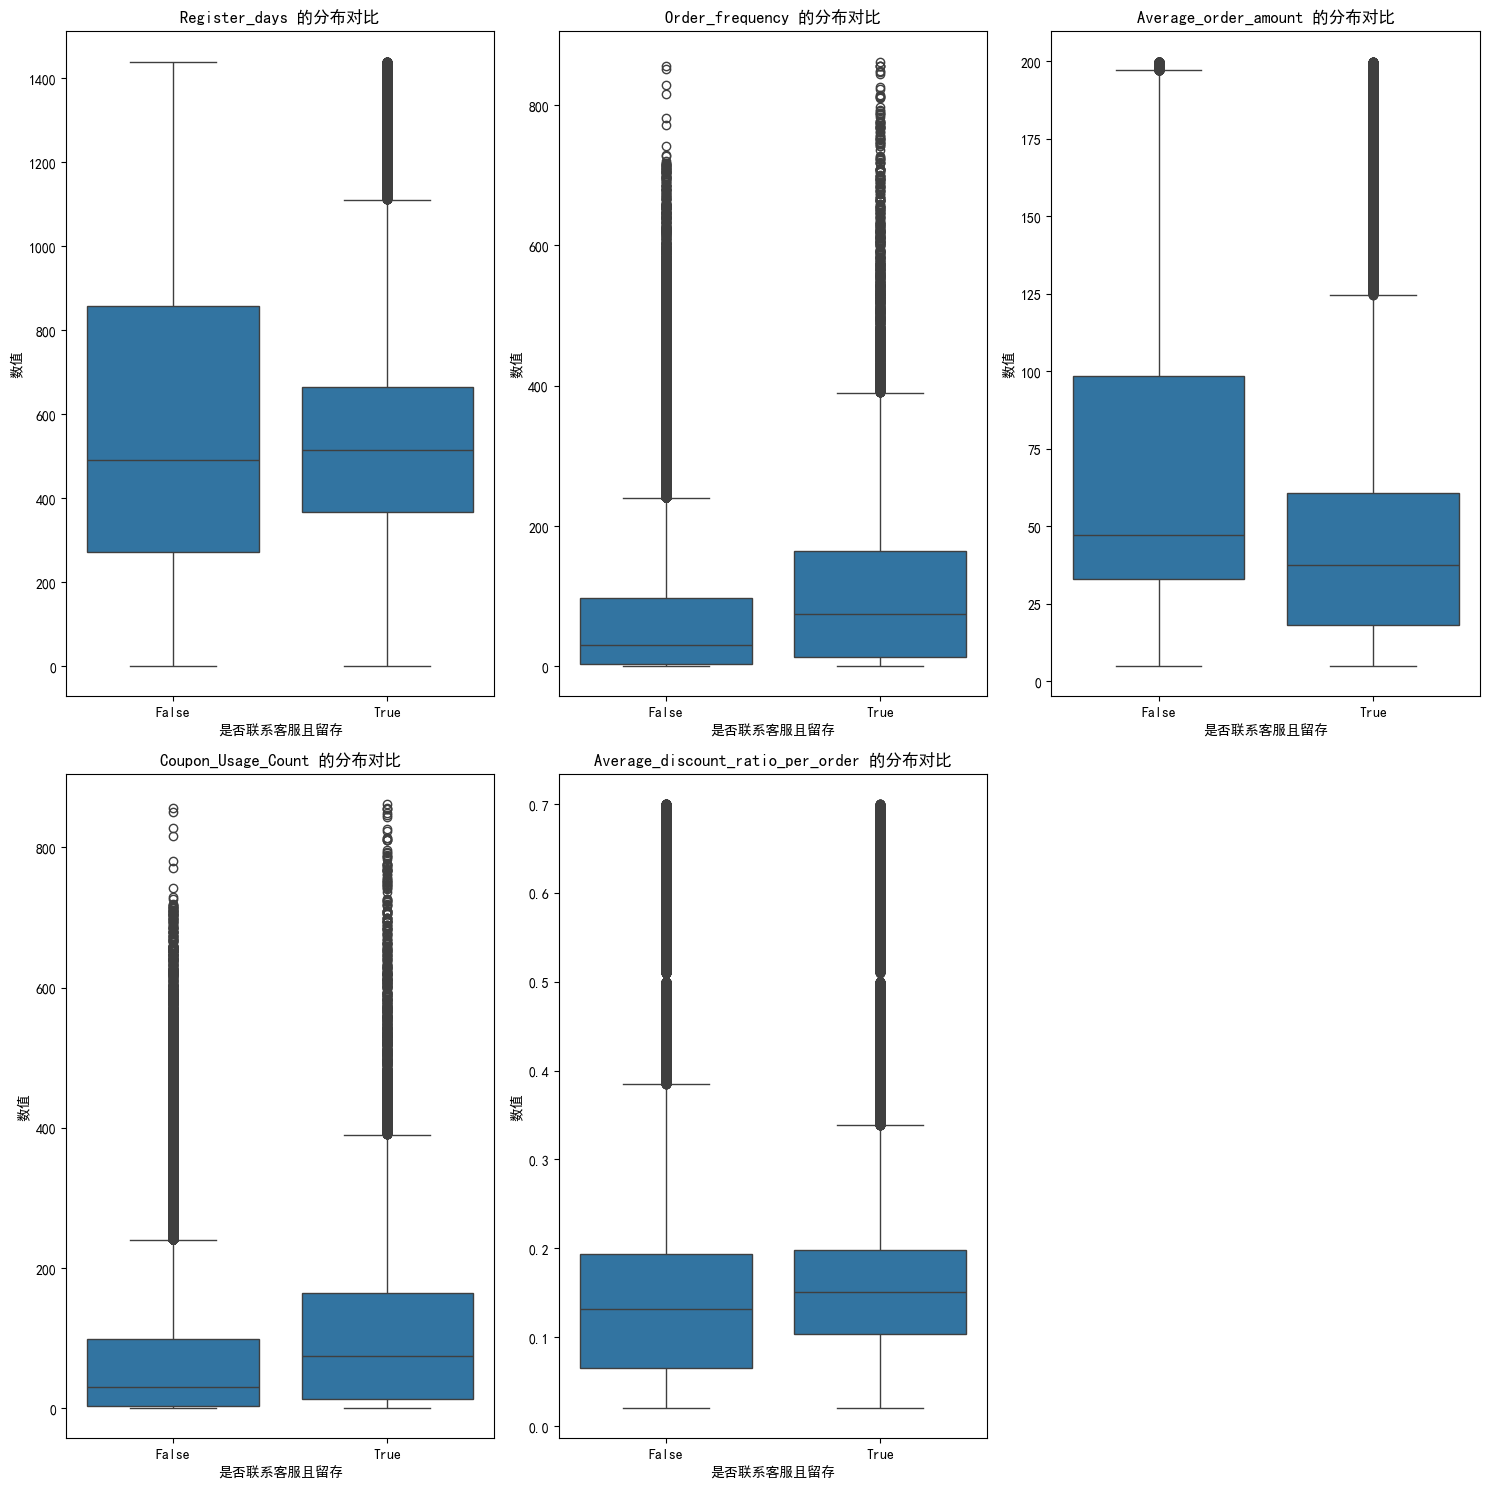

In [23]:
# 需要绘制的特征列表
features = [
    'Register_days',
    'Order_frequency',
    'Average_order_amount',
    'Coupon_Usage_Count',
    'Average_discount_ratio_per_order'
]

plt.figure(figsize=(15, 15))

# 逐个特征绘制子图
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(
        data=data,
        x='if_conact_and_re',
        y=feature
    )
    plt.title(f"{feature} 的分布对比")
    plt.xlabel('是否联系客服且留存')
    plt.ylabel('数值')
plt.tight_layout()
plt.show()

观察箱线图发现，两类群体的注册天数，联系客服且留存的消费者均值低但中位数高，同时有大量值较高的离群值，可能说明数据有分布偏向。
初步判定为有一些极新的用户拉低了联系客服且留存消费者群体的注册天数均值，所以我们进一步绘制密度图观察其分布。

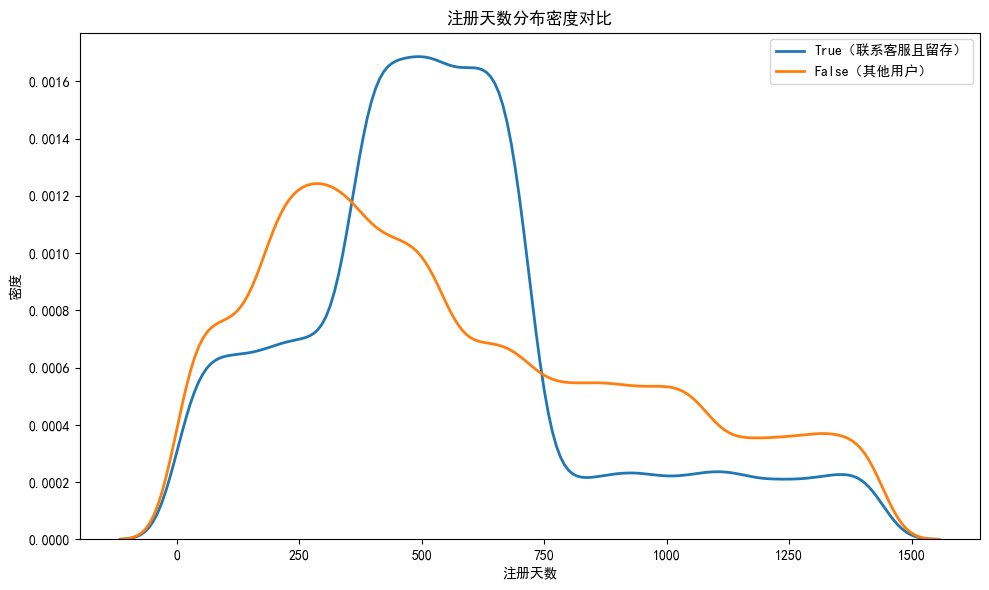

In [24]:
# 设置中文显示
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 设置画布
plt.figure(figsize=(10, 6))

# 绘制 True 组密度曲线
sns.kdeplot(
    data=data[data['if_conact_and_re'] == True],
    x='Register_days',
    label='True（联系客服且留存）',
    linewidth=2
)

# 绘制 False 组密度曲线
sns.kdeplot(
    data=data[data['if_conact_and_re'] == False],
    x='Register_days',
    label='False（其他用户）',
    linewidth=2
)
plt.title('注册天数分布密度对比')
plt.xlabel('注册天数')
plt.ylabel('密度')
plt.legend()
plt.tight_layout()
plt.show()

通过密度图可以看出：联系客服且留存的消费者注册天数曲线峰值明显，曲线较陡，且在新用户和老用户的分布密度均低于其他消费者。而其他消费者注册天数曲线较平缓分布更分散。
说明联系客服且留存消费者的主力群体为中等注册时长的用户，偏向于核心用户群。

同时我们对其他四个特征也绘制密度分布曲线

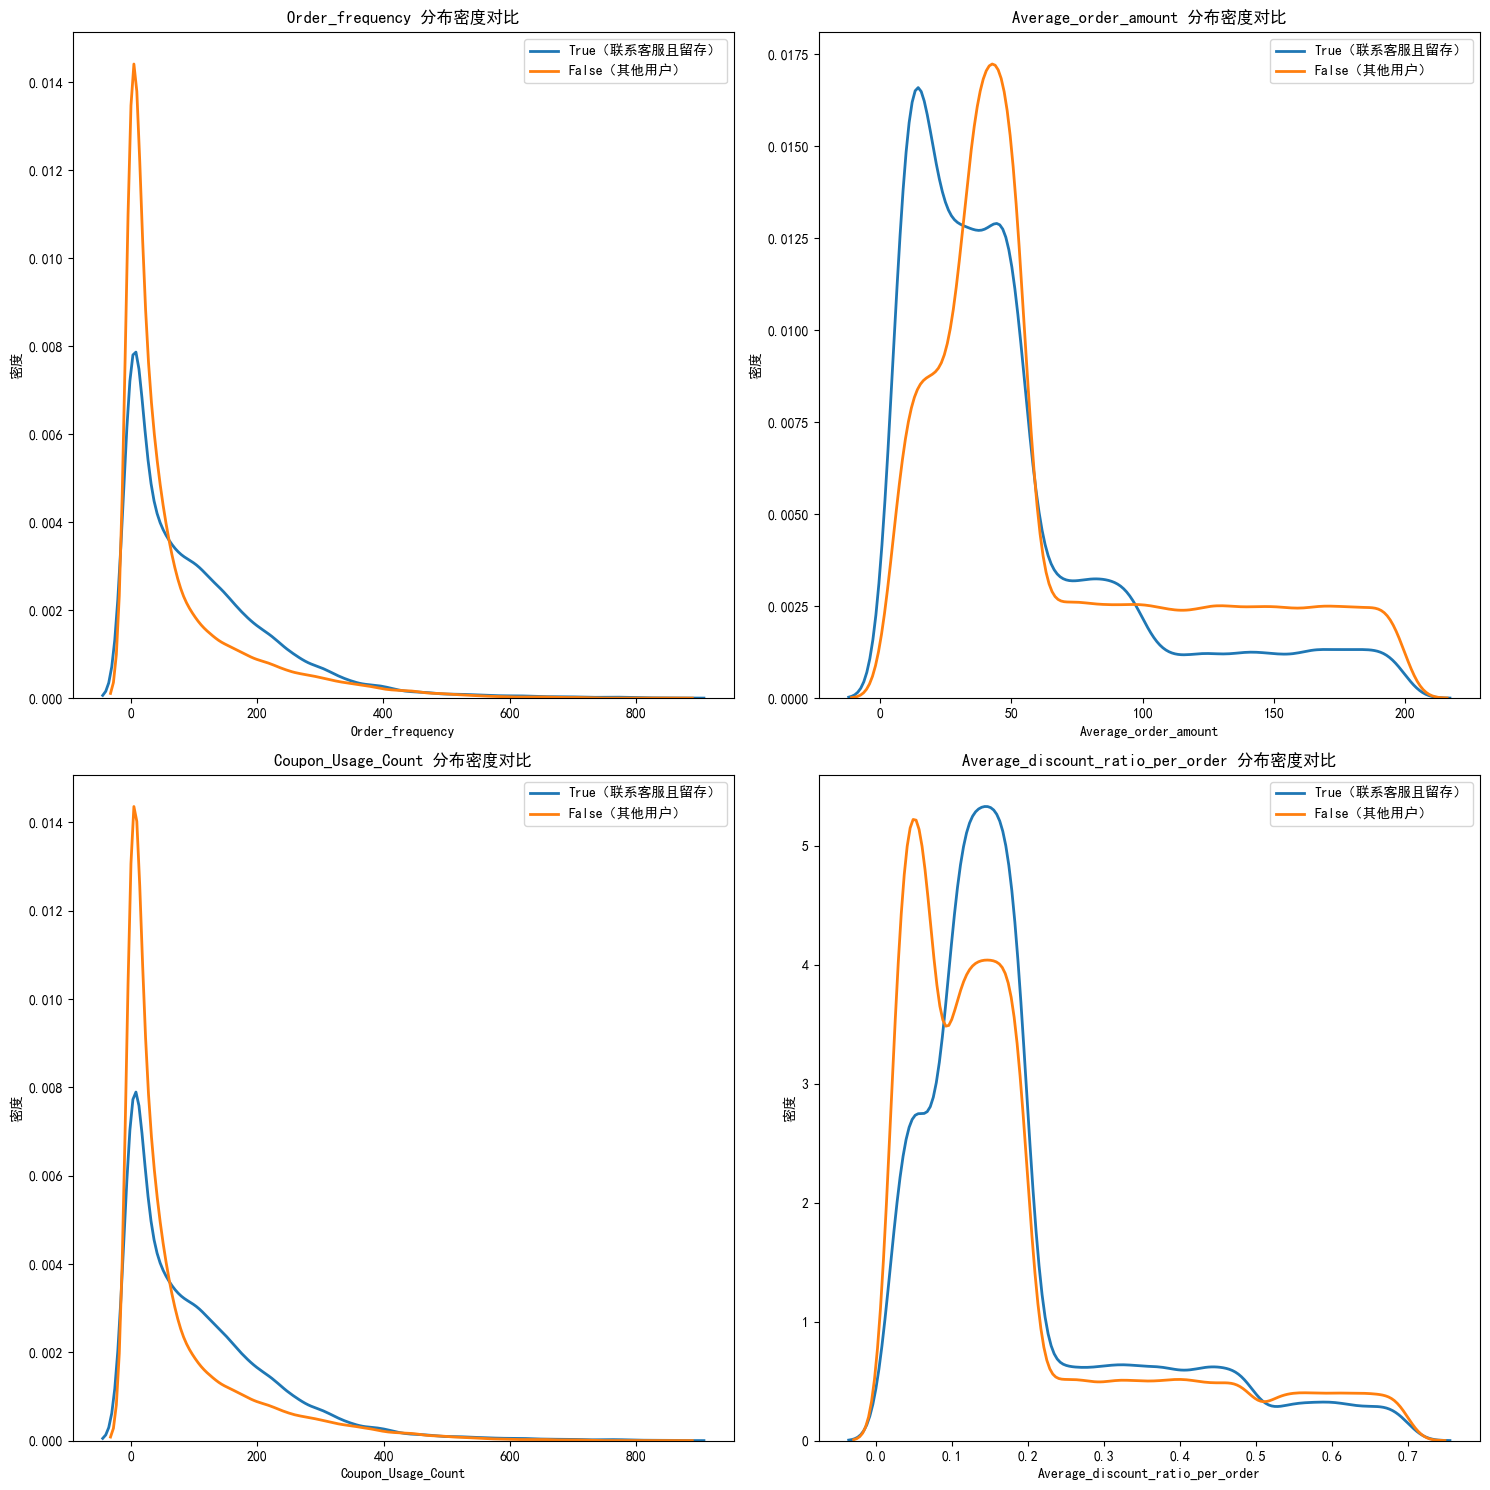

In [25]:
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

features = [
    'Order_frequency',
    'Average_order_amount',
    'Coupon_Usage_Count',
    'Average_discount_ratio_per_order'
]

plt.figure(figsize=(15, 15))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    
    sns.kdeplot(
        data=data[data['if_conact_and_re'] == True],
        x=feature,
        label='True（联系客服且留存）',
        linewidth=2
    )
    
    sns.kdeplot(
        data=data[data['if_conact_and_re'] == False],
        x=feature,
        label='False（其他用户）',
        linewidth=2
    )
    
    plt.title(f'{feature} 分布密度对比')
    plt.xlabel(feature)
    plt.ylabel('密度')
    plt.legend()

plt.tight_layout()
plt.show()

# 结论：联系客服且留存的消费者特征

#### 1.主体为中等注册时长的消费者。  
#### 2.该消费者群体下单次数高于其他消费者，大体为高活跃度消费者。  
#### 3.客单价较低，可能对价格更敏感，消费行为偏向“小额+多次”。  
#### 4.使用优惠券次数多且平均每笔订单的优惠比例高，在有优惠或更明显优惠力度时更容易购买。  

## ps:
进行聚类分析，在无监督视角下观察数据

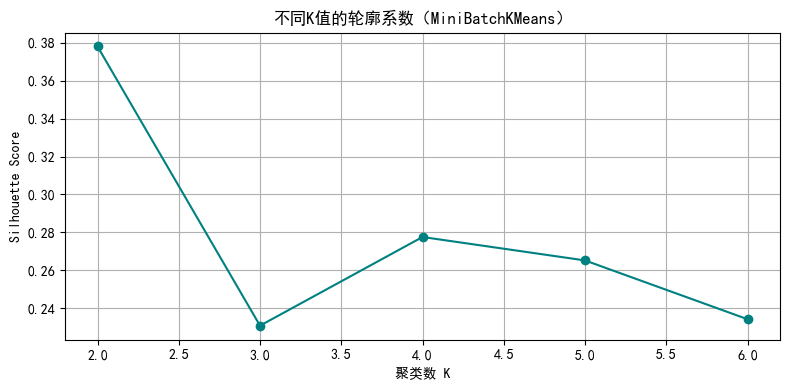

 推荐聚类数 K = 2（轮廓系数最高）


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

# 1. 特征选择
features = [
    'Register_days',
    'Order_frequency',
    'Average_order_amount',
    'Coupon_Usage_Count',
    'Average_discount_ratio_per_order'
]

X = data[features].dropna()

# 2. 标准化
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 3. 抽样（降低计算量）
X_sample = resample(X_sc, n_samples=3000, random_state=42)

# 4. 轮廓系数评估（使用 MiniBatchKMeans 加速）
silhouette_scores = []
K_range = range(2, 7)  # 推荐 K=2~6，超过计算量大

for k in K_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024)
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    silhouette_scores.append(score)

# 5. 可视化轮廓系数 vs 聚类数
plt.figure(figsize=(8, 4))
plt.plot(K_range, silhouette_scores, marker='o', color='teal')
plt.title('不同K值的轮廓系数（MiniBatchKMeans）')
plt.xlabel('聚类数 K')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. 输出最佳 K
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f' 推荐聚类数 K = {best_k}（轮廓系数最高）')

In [30]:
from sklearn.cluster import KMeans

# 1. 重新标准化全量数据
X_full = data[features].dropna()
X_sc = sc.fit_transform(X_full)

# 2. 正式执行聚类（使用最佳K）
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_sc)

# 3. 将聚类标签添加回原始数据
X_full = X_full.copy()
X_full['cluster'] = cluster_labels
X_full['if_contact_and_repurchase'] = data.loc[X_full.index, 'if_conact_and_re']

# 4. 聚类中心（还原为原始特征）
centers = pd.DataFrame(
    sc.inverse_transform(kmeans.cluster_centers_),
    columns=features
)
centers.index.name = 'cluster'

每个聚类簇中 联系客服且回购 的比例：


if_contact_and_repurchase,False,True
cluster,,
0,0.768242,0.231758
1,0.687271,0.312729


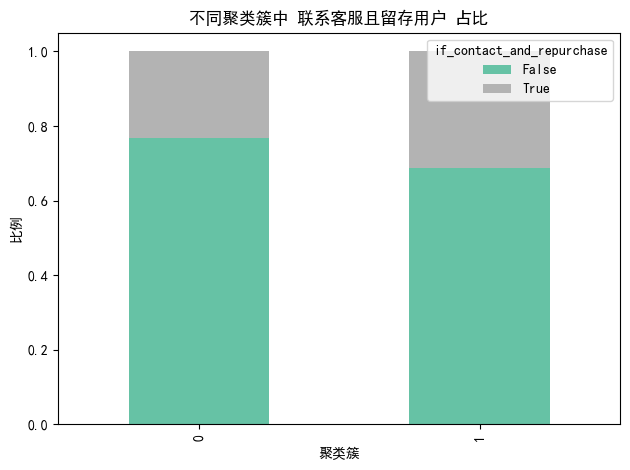

In [31]:
# 6. 交叉表：每个聚类中 True / False 的占比
cross_tab = pd.crosstab(X_full['cluster'], X_full['if_contact_and_repurchase'], normalize='index')
print("每个聚类簇中 联系客服且回购 的比例：")
display(cross_tab)

# 7. 可视化各簇中 True 占比
cross_tab.plot(kind='bar', stacked=True, colormap='Set2')
plt.title("不同聚类簇中 联系客服且留存用户 占比")
plt.ylabel("比例")
plt.xlabel("聚类簇")
plt.tight_layout()
plt.show()

由图可得聚类效果不理想，尝试使用密度聚类方法

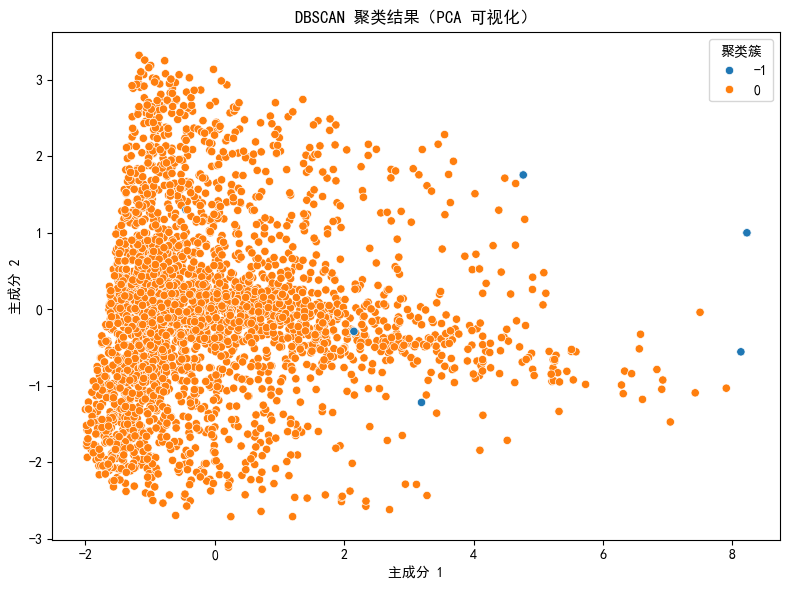

每个聚类簇的样本数量：
dbscan_cluster
-1       9
 0    2991
Name: count, dtype: int64


In [32]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.utils import resample


# 1. 特征选择 + 去除缺失值
features = [
    'Register_days',
    'Order_frequency',
    'Average_order_amount',
    'Coupon_Usage_Count',
    'Average_discount_ratio_per_order'
]
X = data[features].dropna()
X = resample(X, n_samples=3000, random_state=42)  # ✅ 随机采样加速

# 2. 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. DBSCAN 聚类（参数可调整）
dbscan = DBSCAN(eps=1.5, min_samples=15)
labels = dbscan.fit_predict(X_scaled)
X['dbscan_cluster'] = labels

# 4. PCA 降维用于可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X['pca1'] = X_pca[:, 0]
X['pca2'] = X_pca[:, 1]

# 5. 可视化聚类分布
plt.figure(figsize=(8, 6))
palette = sns.color_palette('tab10', len(np.unique(labels)))
sns.scatterplot(data=X, x='pca1', y='pca2', hue='dbscan_cluster', palette=palette, legend='full')
plt.title('DBSCAN 聚类结果（PCA 可视化）')
plt.xlabel('主成分 1')
plt.ylabel('主成分 2')
plt.legend(title='聚类簇')
plt.tight_layout()
plt.show()

# 6. 查看聚类簇样本数
print("每个聚类簇的样本数量：")
print(X['dbscan_cluster'].value_counts().sort_index())

根据图可得，绝大多数消费者被聚入同一簇，未能形成清晰分群结构，样本缺乏可分性，聚类难度较大。

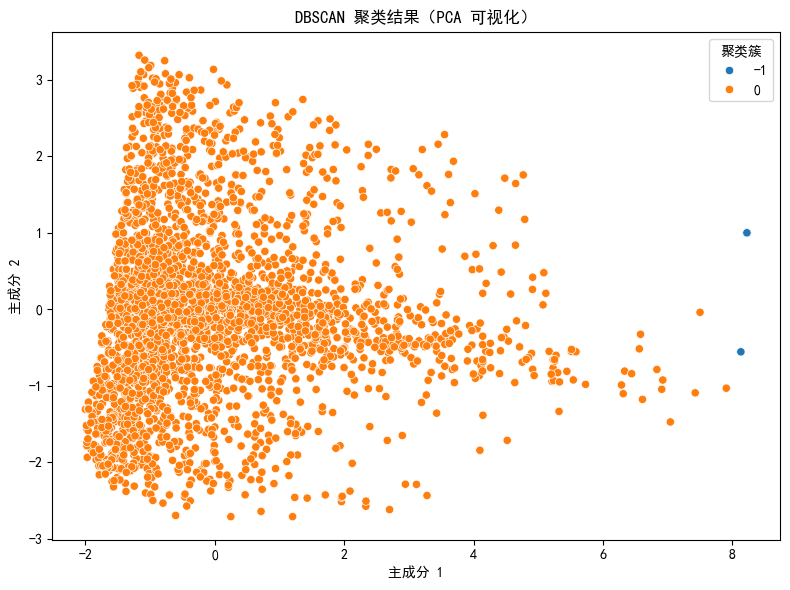

每个聚类簇的样本数量：
dbscan_cluster
-1       4
 0    2996
Name: count, dtype: int64


In [34]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.utils import resample


# 1. 特征选择 + 去除缺失值
features = [
    'Register_days',
    'Order_frequency',
    'Average_order_amount',
    'Coupon_Usage_Count',
    'Average_discount_ratio_per_order'
]
X = data[features].dropna()
X = resample(X, n_samples=3000, random_state=42)  # ✅ 随机采样加速

# 2. 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. DBSCAN 聚类（参数可调整）
dbscan = DBSCAN(eps=2, min_samples=20)
labels = dbscan.fit_predict(X_scaled)
X['dbscan_cluster'] = labels

# 4. PCA 降维用于可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X['pca1'] = X_pca[:, 0]
X['pca2'] = X_pca[:, 1]

# 5. 可视化聚类分布
plt.figure(figsize=(8, 6))
palette = sns.color_palette('tab10', len(np.unique(labels)))
sns.scatterplot(data=X, x='pca1', y='pca2', hue='dbscan_cluster', palette=palette, legend='full')
plt.title('DBSCAN 聚类结果（PCA 可视化）')
plt.xlabel('主成分 1')
plt.ylabel('主成分 2')
plt.legend(title='聚类簇')
plt.tight_layout()
plt.show()

# 6. 查看聚类簇样本数
print("每个聚类簇的样本数量：")
print(X['dbscan_cluster'].value_counts().sort_index())

尝试调整参数，结果仍不理想。放弃聚类方法

尝试决策树方法分类

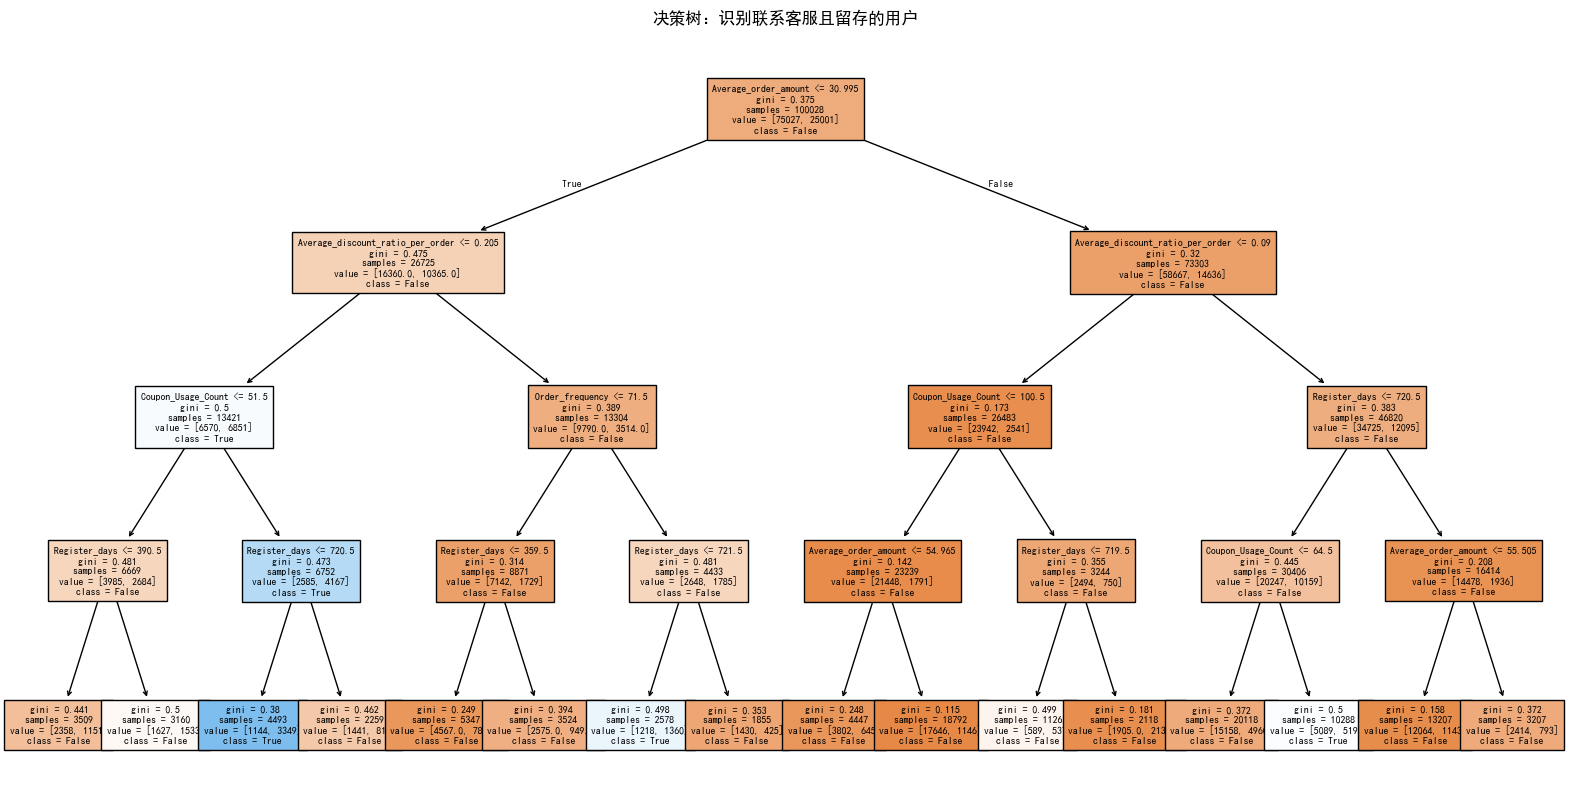

模型评估报告：
              precision    recall  f1-score   support

       False       0.82      0.90      0.86     18819
        True       0.57      0.40      0.47      6188

    accuracy                           0.78     25007
   macro avg       0.70      0.65      0.66     25007
weighted avg       0.76      0.78      0.76     25007

混淆矩阵：
[[16984  1835]
 [ 3733  2455]]


In [42]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. 准备数据
features = [
    'Register_days',
    'Order_frequency',
    'Average_order_amount',
    'Coupon_Usage_Count',
    'Average_discount_ratio_per_order'
]
X = data[features].dropna()
y = data.loc[X.index, 'if_conact_and_re']  # 目标变量

# 2. 划分训练/测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 建立决策树模型
clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=100, random_state=42)
clf.fit(X_train, y_train)

# 4. 可视化决策树结构
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=features, class_names=['False', 'True'], filled=True, fontsize=7)
plt.title("决策树：识别联系客服且留存的用户")
plt.show()

# 5. 模型评估
y_pred = clf.predict(X_test)
print("模型评估报告：")
print(classification_report(y_test, y_pred))
print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred))

模型评估：True类召回率较低，说明模型在评估True类方面局限性较大

观察得：叶节点中True类较多的节点拥有的共同分类特征为注册天数小于720.5天，其中两个有分类特征优惠券使用次数大于51.5或64.5，一个有下单次数大于71.5分类特征。说明主动联系客服且留存消费者群体画像为为注册时长中等，使用优惠券次数多，较活跃的消费者。

尝试随机森林方法

随机森林模型评估报告：
              precision    recall  f1-score   support

       False       0.82      0.95      0.88     18819
        True       0.72      0.36      0.48      6188

    accuracy                           0.81     25007
   macro avg       0.77      0.66      0.68     25007
weighted avg       0.79      0.81      0.78     25007

混淆矩阵：
[[17935   884]
 [ 3948  2240]]


C:\Users\倪商\AppData\Local\Temp\ipykernel_24844\2230376756.py:46: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) SimHei.
  plt.tight_layout()
D:\python\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


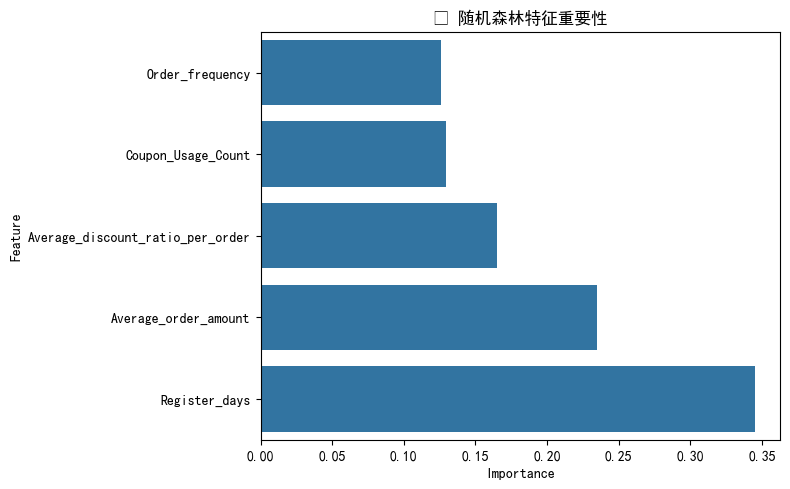

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 数据准备
features = [
    'Register_days',
    'Order_frequency',
    'Average_order_amount',
    'Coupon_Usage_Count',
    'Average_discount_ratio_per_order'
]
X = data[features].dropna()
y = data.loc[X.index, 'if_conact_and_re']

# 2. 划分训练/测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 建立随机森林模型
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42
)
rf.fit(X_train, y_train)

# 4. 预测与评估
y_pred = rf.predict(X_test)
print("随机森林模型评估报告：")
print(classification_report(y_test, y_pred))
print("混淆矩阵：")
print(confusion_matrix(y_test, y_pred))

# 5. 特征重要性可视化
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("🌲 随机森林特征重要性")
plt.tight_layout()
plt.show()

使用随机森林提升了准确率和预测True类精准率

模型认为：一个注册时间适中、客单价较低、使用较多优惠券、享受较多优惠的用户，最有可能成为联系客服且留存的用户。